In [1]:
import math
import pickle
import gzip
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

# Set random seed for deterministic output
np.random.seed(5622)

In [ ]:
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import TweetTokenizer
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn import preprocessing
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
#test model function
def report_results(model, X, y):
    # Reports various model metrics.  
    pred = model.predict(X)        
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [ ]:
def linear_plot(X, y, w=None, b=None):
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
    
    # Plot data 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.scatter(X[:,0], X[:,1], color=colors, s=150, alpha=0.95, zorder=2)
    
    # Plot boundaries 
    lower_left = np.min([np.min(X[:,0]), np.min(X[:,1])])
    upper_right = np.max([np.max(X[:,0]), np.max(X[:,1])])
    gap = .1*(upper_right-lower_left)
    xplot = np.linspace(lower_left-gap, upper_right+gap, 20)
    if w is not None and b is not None: 
        ax.plot(xplot, (-b - w[0]*xplot)/w[1], color="gray", lw=2, zorder=1)
        ax.plot(xplot, ( 1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        ax.plot(xplot, (-1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        
    
    ax.set_xlim([lower_left-gap, upper_right+gap])
    ax.set_ylim([lower_left-gap, upper_right+gap])
    
    ax.grid(alpha=0.25)

In [ ]:
def nonlinear_plot(X, y, clf=None): 
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,15))
    
    colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
    ax.scatter(X[:,0],X[:,1], marker='o', color=colors, s=100, alpha=0.5)
    
#     ax.arrow(-1.25,0,2.5,0, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
#     ax.arrow(0,-1.25,0,2.5, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    z = np.linspace(0.25,3.5,10)
    
#     ax.set_xlim([-1.50,1.50])
#     ax.set_ylim([-1.50,1.50])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([], fontsize=16)
    plt.yticks([], fontsize=16)
    

    if clf: 
        
        clf.fit(X,y)

        x_min = X[:, 0].min()+.00
        x_max = X[:, 0].max()-.00
        y_min = X[:, 1].min()+.00
        y_max = X[:, 1].max()-.00

        colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
#         print("XX: ",XX)
#         print("YY: ",YY)
#         print("Z: ",Z)
        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
#         print("newZ: ",Z)
        plt.contour(XX, YY, Z, colors=[mycolors["blue"], "gray", mycolors["red"]], linestyles=['--', '-', '--'],
                    levels=[-1.0, 0, 1.0],linewidths=[2,2,2], alpha=0.9)#levels=[-1.0, 0, 1.0], 
    

In [ ]:
#read in csv file and create data frame
df = pd.read_csv("first_data.csv")
# df_u = df.drop_duplicates(subset=None)
# df_u.tail(40)
df
df_t = pd.read_csv("tianwei_data.csv").head(46)
df_t
df_tL = pd.read_csv("tianwei_large.csv")
df_tL
frames = [df, df_t, df_tL]
df_n = pd.concat(frames)
df_n = df_n.reset_index()
df_n

#first thing pair sell and buy price together

,index,side,size,price,volume,turnover,label
0,0,Sell,710,15760.0,83560,14698725070,-1
1,1,Sell,651,15759.0,83560,14698725070,-1
2,2,Sell,1224,15758.5,83560,14698725070,1
3,3,Sell,1385,15755.5,83560,14698725070,-1
4,4,Sell,630,15753.0,83560,14698725070,1
...,...,...,...,...,...,...,...
1007,915,Buy,3000,17505.0,5028,932548065,1
1008,916,Buy,193,17500.0,5028,932548065,-1
1009,917,Buy,100,17499.5,5028,932548065,1
1010,918,Buy,50,17490.0,5028,932548065,1


In [ ]:
new_col = []
ARIMA_pred =[]
for i in range(0, len(df_n)):
    if(i>3):
        if(i<30):
            model = ARIMA(np.array(df_n["price"][0:i]), order=(1,0,0))       
        else:
            model = ARIMA(np.array(df_n["price"][i-30:i]), order=(1,0,0))
        model_fit = model.fit()
        yhat = model_fit.predict(0, 0)
        #predicted price
        new_col.append(yhat[0]) 
    else:
        new_col.append(df_n["price"][i])
    if(new_col[i] > df_n["price"][i]): 
        ARIMA_pred.append(-1)
    else:
        ARIMA_pred.append(1)
df_n["ARIMA"] = new_col
df_n["ARIMA_pred"] = ARIMA_pred

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python

In [ ]:
df_n

,index,side,size,price,volume,turnover,label,ARIMA,ARIMA_pred
0,0,Sell,710,15760.0,83560,14698725070,-1,15760.000000,1
1,1,Sell,651,15759.0,83560,14698725070,-1,15759.000000,1
2,2,Sell,1224,15758.5,83560,14698725070,1,15758.500000,1
3,3,Sell,1385,15755.5,83560,14698725070,-1,15755.500000,1
4,4,Sell,630,15753.0,83560,14698725070,1,15758.180334,-1
...,...,...,...,...,...,...,...,...,...
1007,915,Buy,3000,17505.0,5028,932548065,1,17617.952258,-1
1008,916,Buy,193,17500.0,5028,932548065,-1,17615.192627,-1
1009,917,Buy,100,17499.5,5028,932548065,1,17611.745733,-1
1010,918,Buy,50,17490.0,5028,932548065,1,17609.210288,-1


In [ ]:
#CELL TO ADD NEW FEATURE TO DATAFRAME

#for both sell and buy
#calculate (currentSize-prevSize)/volume and add the value to a new column named des
#1. try and add the actual result of the calculation
#2. try and add 1 if result positive and -1 if result is negative

#first sell and first buy don't have previous (maybe subtract -0)


In [ ]:
#count number of -1 and 1 labels
count_min = 0
count_pos = 0
main_size = len(df_n.index)
#----------------------------------------
for i in range(main_size):
    label = df_n["label"].iloc[i]
    if label == 1:
        count_pos += 1
    else:
        count_min += 1
print("+1: ",count_pos)
print("-1: ",count_min)

+1:  756
-1:  256


In [ ]:
df_sell = df_n.loc[df_n["side"] == "Sell"]
df_sell = df_sell.reset_index()
df_buy = df_n.loc[df_n["side"] == "Buy"]
df_buy = df_buy.reset_index()
#test data
import random
r_ind = random.sample(range(506), 100)#in the future change these values
df_bTest = pd.DataFrame()
df_sTest = pd.DataFrame()
#get data
df_btest = df_buy.loc[r_ind]
df_stest = df_sell.loc[r_ind]

df_buy = df_buy.drop(r_ind)
df_sell = df_sell.drop(r_ind)

del df_buy["level_0"]
del df_sell["level_0"]
df_sell = df_sell.reset_index()
df_buy = df_buy.reset_index()

# del df_bTest["level_0"]
# del df_sTest["level_0"]
df_btest = df_btest.drop(['level_0'], axis=1)
df_stest = df_stest.drop(['level_0'], axis=1)
# df_btest = df_buy.reset_index()
df_btest = df_btest.reset_index()
df_stest = df_stest.reset_index()
df_btest

,level_0,index,side,size,price,volume,turnover,label,ARIMA,ARIMA_pred
0,482,873,Buy,3000,17471.0,5028,932548065,1,17603.265430,-1
1,308,538,Buy,800,16564.0,5028,932548065,1,16684.834685,-1
2,341,594,Buy,100,16574.5,5028,932548065,1,16656.687699,-1
3,193,308,Buy,1668,16578.0,5028,932548065,-1,16641.540095,-1
4,490,904,Buy,234,17569.5,5028,932548065,1,17678.392118,-1
...,...,...,...,...,...,...,...,...,...,...
95,276,483,Buy,811,16654.0,5028,932548065,-1,16741.285401,-1
96,478,869,Buy,50,17490.0,5028,932548065,-1,17622.405608,-1
97,25,25,Buy,159,15888.0,4889,876005695,1,15830.101017,1
98,376,675,Buy,51,16638.5,5028,932548065,1,16700.954531,-1


In [ ]:
#get 1 in all column
df_sell['des'] = 1
df_buy['des'] = 1
#set first to 0
df_sell.at[0,'des'] = 0
df_buy.at[0,'des'] = 0
#now iterate and calculate (currentSize-prevSize)/volume
size = len(df_sell.index)
for i in range(size):
    if i != 0:
        df_sell['des'].iloc[i] = (df_sell['size'].iloc[i]-df_sell['size'].iloc[i-1])/df_sell['volume'].iloc[i]
        df_buy['des'].iloc[i] = (df_buy['size'].iloc[i]-df_buy['size'].iloc[i-1])/df_buy['volume'].iloc[i]
df_sell

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,level_0,index,side,size,price,volume,turnover,label,ARIMA,ARIMA_pred,des
0,0,0,Sell,710,15760.0,83560,14698725070,-1,15760.000000,1,0.000000
1,1,1,Sell,651,15759.0,83560,14698725070,-1,15759.000000,1,-0.000706
2,2,2,Sell,1224,15758.5,83560,14698725070,1,15758.500000,1,0.006857
3,3,3,Sell,1385,15755.5,83560,14698725070,-1,15755.500000,1,0.001927
4,4,4,Sell,630,15753.0,83560,14698725070,1,15758.180334,-1,-0.009035
...,...,...,...,...,...,...,...,...,...,...,...
401,500,891,Sell,302,17709.5,5028,932548065,1,17638.174085,1,0.040175
402,501,892,Sell,300,17702.0,5028,932548065,1,17638.929735,1,-0.000398
403,502,893,Sell,2780236,17700.0,5028,932548065,-1,17640.650893,1,552.891010
404,503,894,Sell,711,17698.0,5028,932548065,1,17642.487739,1,-552.809268


In [ ]:
df_stest['des'] = 1
df_btest['des'] = 1
#set first to 0
df_stest.at[0,'des'] = 0
df_btest.at[0,'des'] = 0
#now iterate and calculate (currentSize-prevSize)/volume
size = len(df_stest.index)
for i in range(size):
    if i != 0:
        df_stest['des'].iloc[i] = (df_stest['size'].iloc[i]-df_stest['size'].iloc[i-1])/df_stest['volume'].iloc[i]
        df_btest['des'].iloc[i] = (df_btest['size'].iloc[i]-df_btest['size'].iloc[i-1])/df_btest['volume'].iloc[i]
df_stest

,level_0,index,side,size,price,volume,turnover,label,ARIMA,ARIMA_pred,des
0,482,850,Sell,302,17709.5,5028,932548065,1,17707.261613,1,0.000000
1,308,515,Sell,50,16772.0,5028,932548065,1,16667.422879,1,-0.050119
2,341,571,Sell,181,16690.5,5028,932548065,1,16655.680061,1,0.026054
3,193,285,Sell,100,16691.5,5028,932548065,-1,16625.350205,1,-0.016110
4,490,881,Sell,1068,17730.0,5028,932548065,1,17630.628473,1,0.192522
...,...,...,...,...,...,...,...,...,...,...,...
95,276,460,Sell,2,16824.0,5028,932548065,-1,16754.805758,1,-0.059666
96,478,846,Sell,300,17724.5,5028,932548065,-1,17703.051463,1,0.059268
97,25,2,Sell,202,15977.0,4889,876005695,1,15672.600514,1,-0.020045
98,376,652,Sell,204,16715.5,5028,932548065,1,16685.333978,1,0.000398


In [ ]:
# df_sell = df_n.loc[df_n["side"] == "Sell"]
# df_sell = df_sell.reset_index()
# df_buy = df_n.loc[df_n["side"] == "Buy"]
# df_buy = df_buy.reset_index()
#pair sell with corresponging buy order, subtract and get abs value,


#get train data for bprice vs sprice
r_count = len(df_sell.index)
X_train = np.zeros((r_count,2))
y_train = np.ones(r_count)
#get labels
for i in range(r_count):
    y_train[i] = df_sell["label"].iloc[i]
    X_train[i,0] = df_sell["price"].iloc[i]
    X_train[i,1] = df_buy["price"].iloc[i]
# #normalize data
# norm_X1 = preprocessing.normalize(X_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


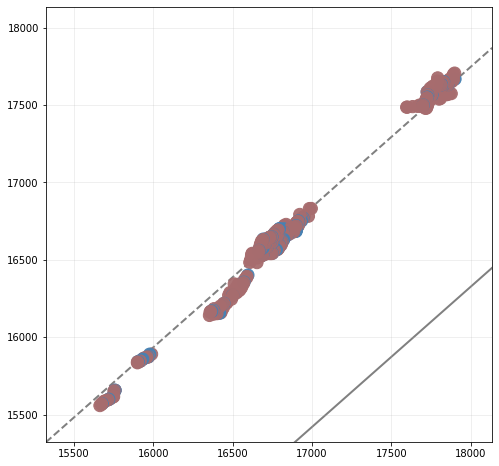

In [ ]:
#FIT AND PLOT MODEL
from sklearn.svm import LinearSVC

# TODO: Train the model and get the parameters, pay attention to the loss parameter
lsvm = LinearSVC(C=50, loss="hinge")
lsvm.fit(X_train,y_train)
w = lsvm.coef_[0]
b = lsvm.intercept_

#WARNING: failing to converge -> LOOK THAT UP

linear_plot(X_train, y_train, w=w, b=b)

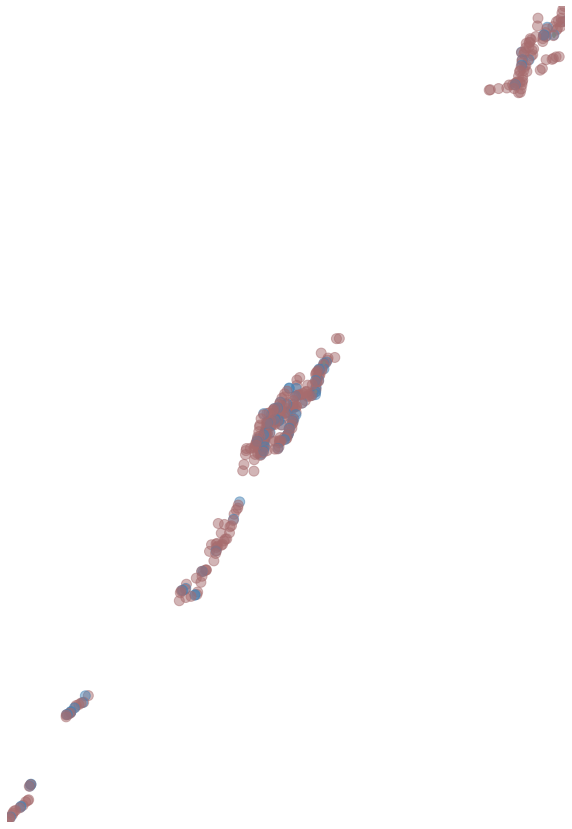

In [ ]:
from sklearn.svm import SVC

nlsvm = SVC(C=100, kernel="rbf",gamma=1)
nlsvm.fit(X_train,y_train)

nonlinear_plot(X_train, y_train, nlsvm)

In [ ]:
#two more things to try:
#- nonlinear svm
#- as well as, buy-sell price difference (abs value) bs size of order

In [ ]:
#new classifier abs difference of price vs ______ size or oder?
# get sell-buy vs volume
r_count = len(df_sell.index)
X_t = np.zeros((r_count,2))
y_t = np.ones(r_count)
#get labels
for i in range(r_count):
    y_t[i] = df_sell["label"].iloc[i]
    X_t[i,0] = df_sell["price"].iloc[i] - df_buy["price"].iloc[i]
    X_t[i,1] = df_sell["size"].iloc[i] - df_buy["size"].iloc[i]
#normalize data
norm_X2 = preprocessing.normalize(X_t,norm='l1')

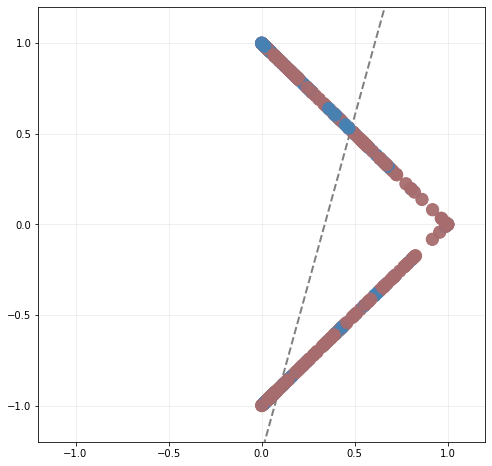

In [ ]:
lsvm = LinearSVC(C=100, loss="hinge")
lsvm.fit(norm_X2,y_t)
w = lsvm.coef_[0]
b = lsvm.intercept_

#WARNING: failing to converge -> LOOK THAT UP

linear_plot(norm_X2, y_t, w=w, b=b)

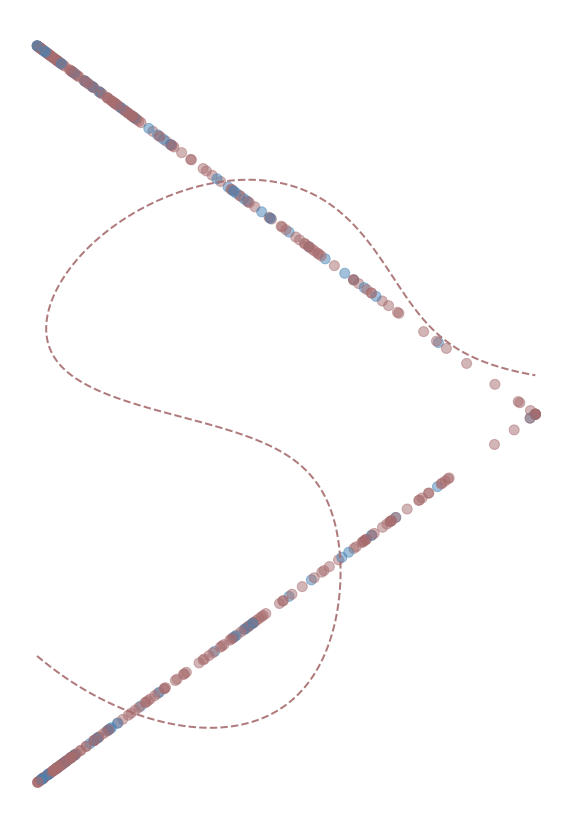

In [ ]:
nlsvm = SVC(C=1, kernel="rbf",gamma=1)
nlsvm.fit(norm_X2,y_t)

nonlinear_plot(norm_X2, y_t, nlsvm)

In [ ]:
#DIFF IN PRICE VS DIFF IN VOLUME

In [ ]:
#new approach

In [ ]:
X_tra = np.zeros((r_count,2))
y_tra = np.ones(r_count)
#get labels
for i in range(r_count):
    y_tra[i] = df_sell["label"].iloc[i]
    X_tra[i,0] = (df_sell["price"].iloc[i] - df_buy["price"].iloc[i])*df_sell["label"].iloc[i]
    X_tra[i,1] = df_sell["size"].iloc[i] - df_buy["size"].iloc[i]
#normalize data
norm_X = preprocessing.normalize(X_tra,norm='l2')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


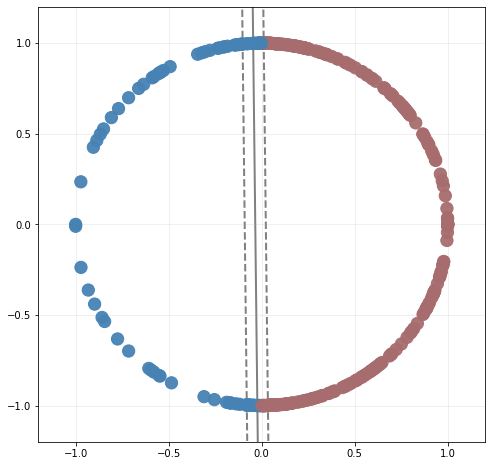

In [ ]:
lsvm = LinearSVC(C=10, loss="hinge")
lsvm.fit(norm_X,y_tra)
w = lsvm.coef_[0]
b = lsvm.intercept_

#WARNING: failing to converge -> LOOK THAT UP

linear_plot(norm_X, y_tra, w=w, b=b)

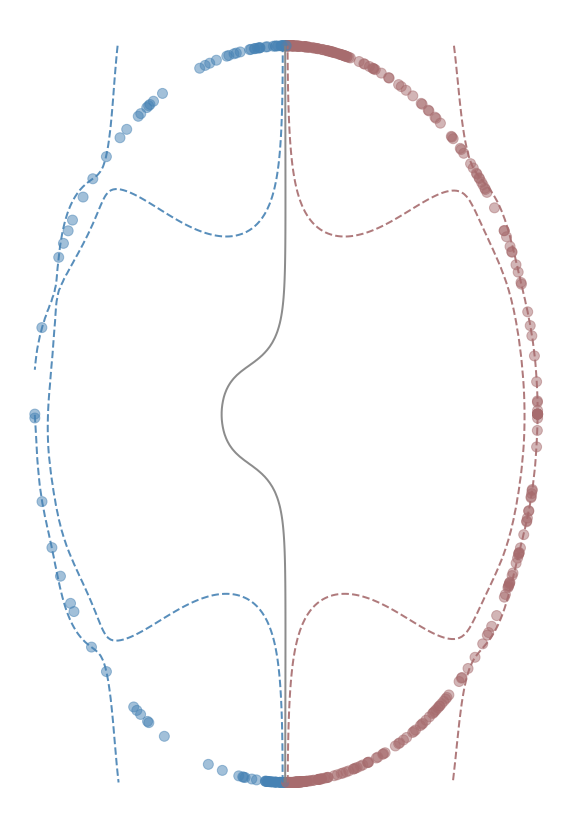

In [ ]:
nlsvm = SVC(C=100, kernel="rbf",gamma=10)


nlsvm.fit(norm_X,y_tra)

nonlinear_plot(norm_X, y_tra, nlsvm)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(nlsvm, norm_X,y_tra)

print("cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))

cross-val mean-accuracy: 0.990


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
#NEW APPROACH TO SEPARATE DEPENDING ON SIGN

In [ ]:
X_tR = np.zeros((r_count,2))
y_tR = np.ones(r_count)
#get labels
# print(sign)
for i in range(r_count):
    sign = np.random.choice([1,-1], p=[0.5, 0.5])
    y_tR[i] = df_sell["label"].iloc[i]
    X_tR[i,0] = (df_sell["price"].iloc[i] - df_buy["price"].iloc[i])*sign
    X_tR[i,1] = df_sell["size"].iloc[i] - df_buy["size"].iloc[i]
#normalize data
norm_XR = preprocessing.normalize(X_tR,norm='l2')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


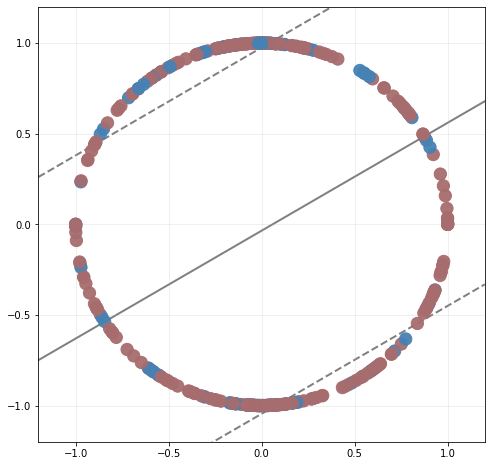

In [ ]:
lsvm = LinearSVC(C=1000, loss="hinge")
lsvm.fit(norm_XR,y_tR)
w = lsvm.coef_[0]
b = lsvm.intercept_

#WARNING: failing to converge -> LOOK THAT UP

linear_plot(norm_XR, y_tR, w=w, b=b)

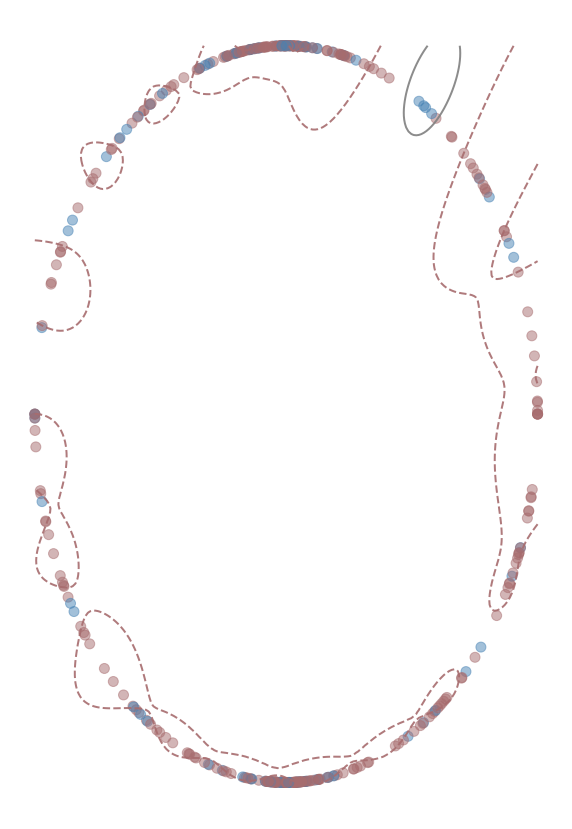

In [ ]:
nlsvm = SVC(C=10, kernel="rbf",gamma=10)


nlsvm.fit(norm_XR,y_tR)

nonlinear_plot(norm_XR, y_tR, nlsvm)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(nlsvm, norm_XR,y_tR)

print("cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))

cross-val mean-accuracy: 0.751


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
#feature standarization
X_tS = np.zeros((r_count,2))
y_tS = np.ones(r_count)
#get labels
# print(sign)
for i in range(r_count):
    sign = np.random.choice([1,-1], p=[0.5, 0.5])
    y_tS[i] = df_sell["label"].iloc[i]
    X_tS[i,0] = (df_sell["price"].iloc[i] - df_buy["price"].iloc[i])*sign
    X_tS[i,1] = df_sell["size"].iloc[i] - df_buy["size"].iloc[i]
#normalize data
norm_XS = preprocessing.scale(X_tS)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


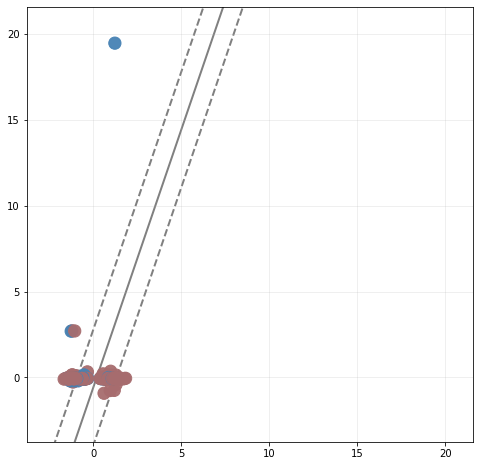

In [ ]:
lsvm = LinearSVC(C=1000, loss="hinge")
lsvm.fit(norm_XS,y_tS)
w = lsvm.coef_[0]
b = lsvm.intercept_

#WARNING: failing to converge -> LOOK THAT UP

linear_plot(norm_XS, y_tS, w=w, b=b)

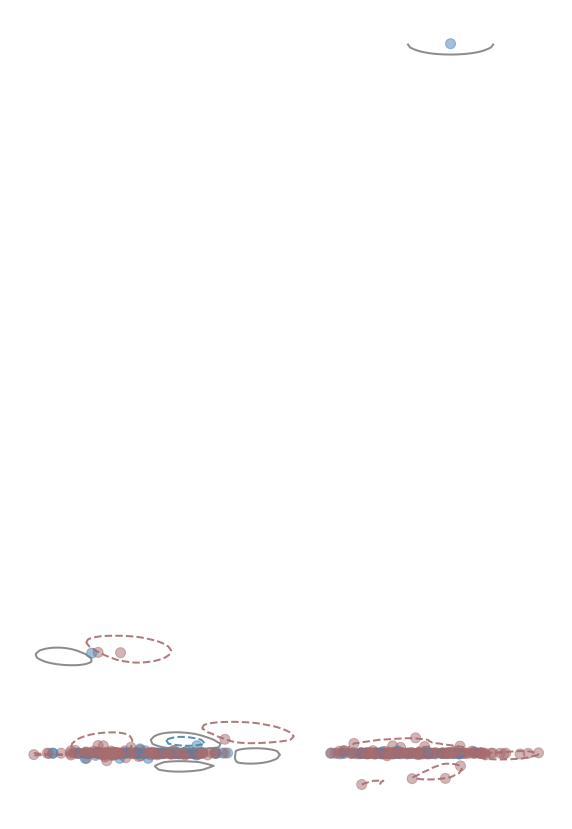

In [ ]:
nlsvm = SVC(C=10, kernel="rbf",gamma=10)


nlsvm.fit(norm_XS, y_tS)

nonlinear_plot(norm_XS, y_tS, nlsvm)

In [ ]:
# THIS LAST MODELS ARE THE BETTER ONES

In [ ]:
#NEW classifier with feature des as sign multiplier
X_tdes = np.zeros((r_count,2))
y_tdes = np.ones(r_count)
#get labels
# print(sign)
for i in range(r_count):
#     diff = df_sell["des"].iloc[i] + df_buy["des"].iloc[i]
    #check each des individually
    des_sell = df_sell.at[i,"des"]
    if(des_sell < 0):
        des_sell = -1
    else:
        des_sell = 1
    des_buy = df_buy.at[i,"des"]
    if(des_buy < 0):
        des_buy = 1
    else:
        des_buy = -1
    


    #check if diff pos or neg
    if((des_buy+des_sell) < 0):
        sign = -1
    else:
        sign = 1
#     #check if diff pos or neg
#     if(diff <= 0):
#         sign = -1
#     else:
#         sign = 1
    
    y_tdes[i] = df_sell["label"].iloc[i]
    X_tdes[i,0] = (df_sell["price"].iloc[i] - df_buy["price"].iloc[i])*sign
    X_tdes[i,1] = df_sell["size"].iloc[i] - df_buy["size"].iloc[i]
#normalize data
norm_Xdes = preprocessing.normalize(X_tdes,norm='l2')


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


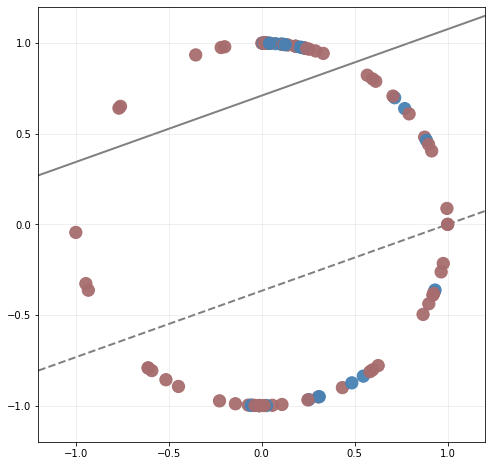

In [ ]:
lsvm = LinearSVC(C=1000, loss="hinge")
lsvm.fit(norm_Xdes,y_tdes)
w = lsvm.coef_[0]
b = lsvm.intercept_

#WARNING: failing to converge -> LOOK THAT UP

linear_plot(norm_Xdes, y_tdes, w=w, b=b)

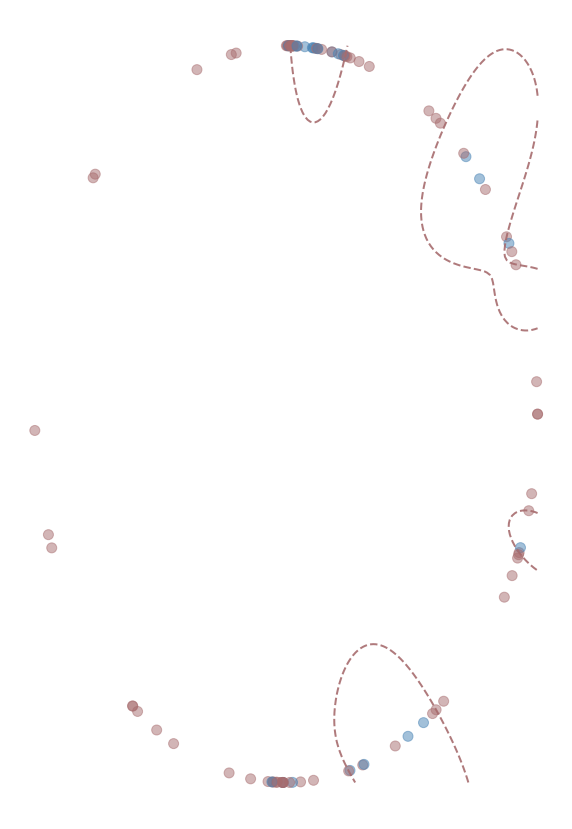

In [ ]:
nlsvm = SVC(C=10, kernel="rbf",gamma=10)


nlsvm.fit(norm_Xdes, y_tdes)

nonlinear_plot(norm_Xdes, y_tdes, nlsvm)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(nlsvm, norm_Xdes,y_tdes)

print("cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))

cross-val mean-accuracy: 0.731


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
r_count = len(df_stest.index)
X_testD = np.zeros((r_count,2))
y_testD = np.ones(r_count)
#get labels
# print(sign)
for i in range(r_count):
#     diff = df_sell["des"].iloc[i] + df_buy["des"].iloc[i]
    #check each des individually
    des_sell = df_stest.at[i,"des"]
    if(des_sell < 0):
        des_sell = -1
    else:
        des_sell = 1
    des_buy = df_btest.at[i,"des"]
    if(des_buy < 0):
        des_buy = 1
    else:
        des_buy = -1
    


    #check if diff pos or neg
    if((des_buy+des_sell) < 0):
        sign = -1
    else:
        sign = 1
#     #check if diff pos or neg
#     if(diff <= 0):
#         sign = -1
#     else:
#         sign = 1
    
    y_testD[i] = df_stest["label"].iloc[i]
    X_testD[i,0] = (df_stest["price"].iloc[i] - df_btest["price"].iloc[i])*sign
    X_testD[i,1] = df_stest["size"].iloc[i] - df_btest["size"].iloc[i]
#normalize data
norm_XtestD = preprocessing.normalize(X_testD,norm='l2')

In [ ]:
report_results(nlsvm, norm_XtestD, y_testD)

{'f1': 0.8023952095808384, 'acc': 0.67, 'precision': 0.67, 'recall': 1.0}

In [ ]:
#ARIMA FEATURE IMPLEMENTED*****************************************************************

In [ ]:
X_ta = np.zeros((r_count,2))
y_ta = np.ones(r_count)
#get labels
# print(sign)

#if arima sell is  +1 and arima buy is -1 == good
#otherwise is bad

for i in range(r_count):
#     sign =    #df_sell["ARIMA_pred"].iloc[i] - df_buy["ARIMA_pred"].iloc[i]
    if df_sell["ARIMA_pred"].iloc[i]== -1 and df_buy["ARIMA_pred"].iloc[i]== 1:
        sign = -1
    elif df_sell["ARIMA_pred"].iloc[i]== 1 and df_buy["ARIMA_pred"].iloc[i]== -1:
        sign = 1
    elif df_sell["ARIMA_pred"].iloc[i]== -1 and df_buy["ARIMA_pred"].iloc[i]== -1:
        sign = 1
    elif df_sell["ARIMA_pred"].iloc[i]== 1 and df_buy["ARIMA_pred"].iloc[i]== 1:
        sign = -1
    else:
        sign = 1
    y_ta[i] = df_sell["label"].iloc[i]
    X_ta[i,0] = (df_sell["price"].iloc[i] - df_buy["price"].iloc[i])*sign
    X_ta[i,1] = df_sell["size"].iloc[i] - df_buy["size"].iloc[i]
#normalize data
norm_Xa = preprocessing.scale(X_ta) #preprocessing.normalize(X_ta,norm='l2')#

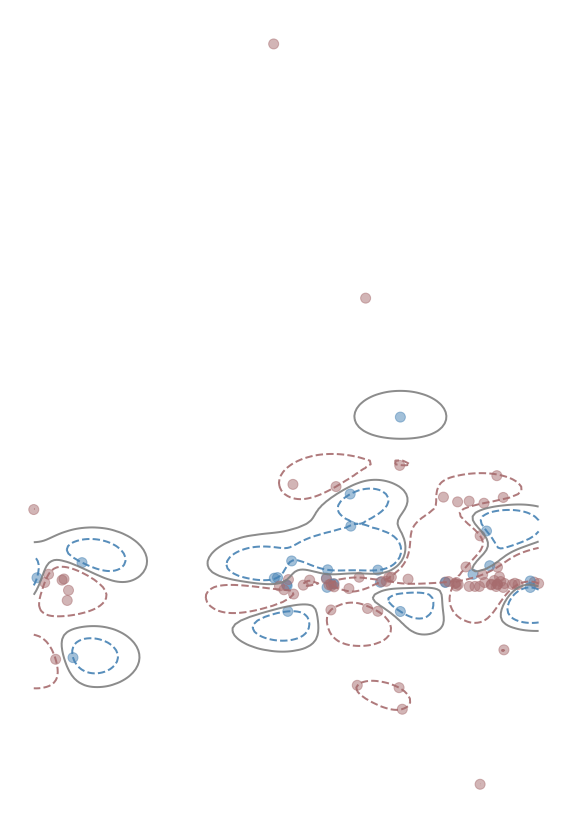

In [ ]:
nlsvm = SVC(C=100, kernel="rbf",gamma=10)

# 0 or 1 be lable
#abs val for labels added together for sell

nlsvm.fit(norm_Xa, y_ta)

nonlinear_plot(norm_Xa, y_ta, nlsvm)

In [ ]:
X_testa = np.zeros((r_count,2))
y_testa = np.ones(r_count)
#get labels
# print(sign)
for i in range(r_count):
    if df_stest["ARIMA_pred"].iloc[i]== -1 and df_btest["ARIMA_pred"].iloc[i]== 1:
        sign = -1
    elif df_sell["ARIMA_pred"].iloc[i]== 1 and df_buy["ARIMA_pred"].iloc[i]== -1:
        sign = 1
    elif df_sell["ARIMA_pred"].iloc[i]== -1 and df_buy["ARIMA_pred"].iloc[i]== -1:
        sign = 1
    elif df_sell["ARIMA_pred"].iloc[i]== 1 and df_buy["ARIMA_pred"].iloc[i]== 1:
        sign = -1
    else:
        sign = 1
    y_testa[i] = df_stest["label"].iloc[i]
    X_testa[i,0] = (df_stest["price"].iloc[i] - df_btest["price"].iloc[i])*sign
    X_testa[i,1] = df_stest["size"].iloc[i] - df_btest["size"].iloc[i]
#normalize data
norm_Xtesta = preprocessing.scale(X_testa) #preprocessing.normalize(X_testa,norm='l2')

In [ ]:
report_results(nlsvm, norm_Xtesta, y_testa)

{'f1': 0.7763157894736843,
 'acc': 0.66,
 'precision': 0.6941176470588235,
 'recall': 0.8805970149253731}

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
#X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(norm_Xa, y_ta)
#RandomForestClassifier(...)
print(clf.predict([[0, 0, 0, 0]]))
print(‘clf: {}’.format(rf_best.score(X_testa, y_testa)))

NameError: ignored

In [ ]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[(‘rf’, clf), (‘SVM’, nlsvm)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting=’hard’)


#fit model to training data
ensemble.fit(norm_Xa, y_ta)
#test our model on the test data
ensemble.score(X_testa, y_testa)